In [1]:
import visa
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Connect to instrument
rm = visa.ResourceManager()
rm.list_resources()

('ASRL3::INSTR', 'GPIB0::22::INSTR')

In [3]:
inst = rm.open_resource('GPIB0::22::INSTR')

In [4]:
class k2410iv():
    """
    
    """
    def __init__(self, vstart=None,vstop=None,pts=None,delay=None):
        rm = visa.ResourceManager()
        rm.list_resources()
        inst = rm.open_resource('GPIB0::22::INSTR')

        np.set_printoptions(threshold=np.nan)
        
        # Define some Parameters
        step = (vstop-vstart)/(pts-1)

        # Initialize Instrument
        rm = visa.ResourceManager()
        rm.list_resources()
        inst = rm.open_resource('GPIB0::22::INSTR')
        # Write Measurement Parameters
        inst.write('*rst; status:preset; *cls')
        inst.write(':status:measurement:enable 512; *sre 1')
        inst.write(':sense:current:nplcycles 0.01')
        inst.write(':route:terminals front')
        inst.write(':sense:average off')
        inst.write(':sense:function:conc off')
        inst.write(':source:function voltage')
        inst.write(":sense:function 'current:dc'")
        inst.write(':sense:current:protection .02')
        inst.write(':sense:current:RANG 10E-6')
        inst.write(':source:voltage:mode sweep')
        inst.write(':SOURce:VOLTage:PROTection 750')
        inst.write(':source:voltage:start '+str(vstart))
        inst.write(':source:voltage:stop '+str(vstop))
        inst.write(':source:voltage:step '+str(step))
        inst.write(':source:sweep:spac lin')
        inst.write(':source:delay '+str(delay))
        inst.write(':arm:source bus')
        
        
        
    def test(self):        
        # Begin Measurement
        inst.write(':trace:poin '+str(pts))
        inst.write(':trigger:count '+str(pts))
        inst.write(':trace:feed sense1')
        inst.write(':trace:feed:control next')
        inst.write(':trace:tstamp:format absolute')
        inst.timeout=None
        inst.write(':output on')
        inst.write(':initiate')
        inst.assert_trigger()
        inst.wait_for_srq(timeout=None)
        inst.write(':output off')
    
    def get_data(self):
        # Read Buffer Data
        inst.timeout=None
        values = np.array(inst.query_ascii_values(':trace:data?'))
        map(float, values)
        # Reset Instrument For Future Measurements
        inst.write(':*cls')
        inst.write(':*sre 0')
        inst.query(':status:measurement?')
        inst.write(':trace:clear')
        inst.write(':output off')
        data=values.reshape((pts,5))
        I = data[:,1]
        v = data[:,0]
        t = data[:,3]
        output=np.array([t,v,I])
        return output
        
        

In [5]:
# instantiate the keithly IV measure class
inst.write(':*cls')
inst.write(':*sre 0')
inst.write(':output off')

testnum=14
vstart=0
vstop=500
pts=2500
delay=.1
step = (vstop-vstart)/(pts-1)
print('voltage step = '+str(step))
print('time duration ~ '+str(pts*delay)+' seconds ('+str(pts*delay/60)+' minutes)')
t1=k2410iv(vstart,vstop,pts,delay)

voltage step = 0.2000800320128051
time duration ~ 250.0 seconds (4.166666666666667 minutes)


In [6]:
# do the measurement
t1.test()

data shape (3, 2500)


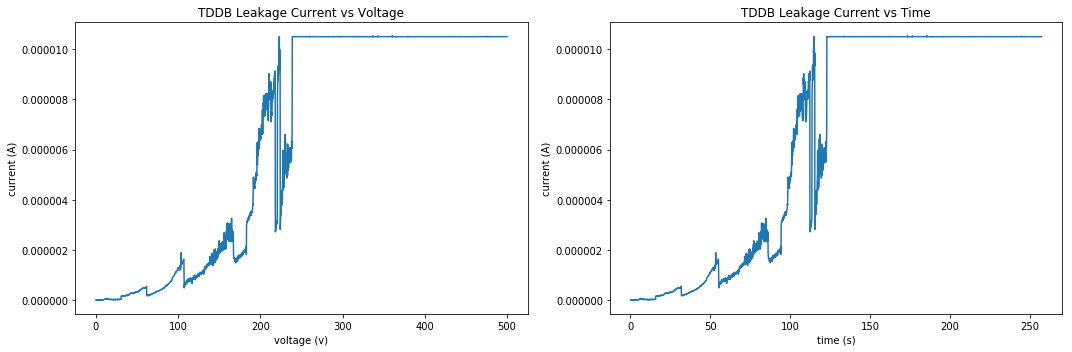

In [7]:
# check the data and plot it
data=t1.get_data()
print('data shape '+str(data.shape))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(data[1,:],data[2,:])
ax1.set_xlabel('voltage (v)')
ax1.set_ylabel('current (A)')

ax1.set_title('TDDB Leakage Current vs Voltage')
ax2.plot(data[0,:],data[2,:])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('current (A)')
ax2.set_title('TDDB Leakage Current vs Time')

plt.tight_layout()
plt.savefig('testnumber'+str(testnum)+'_'+str(vstart)+'_'+str(vstop)+'v'+str(pts)+'pts'+str(delay)+'d_combined_2410.png',dpi=500)

In [8]:
# Save the data to a .txt file and check file
np.savetxt('testnumber'+str(testnum)+'_'+str(vstart)+'_'+str(vstop)+'v'+str(pts)+'pts'+str(delay)+'d_2410.txt', data)
check = np.loadtxt('testnumber'+str(testnum)+'_'+str(vstart)+'_'+str(vstop)+'v'+str(pts)+'pts'+str(delay)+'d_2410.txt')
print('saving the file worked! here is the data shape from the file: '+str(check.shape))

saving the file worked! here is the data shape from the file: (3, 2500)
